###Import the required modules and mount drive

In [ ]:
import os
import cv2
import pickle
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D,Flatten
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fldr="/content/drive/MyDrive/Machine Learning/Final Project/UTKFace"
files=os.listdir(fldr)

###Reading the Images into gray fromat of size 100x100

In [ ]:
import tqdm
ageList=[]
genderList=[]
imagesList=[]

for file in tqdm.tqdm(files, total = 23713,desc ="Retrieving"):
      age=int(file.split('_')[0])
      gender=int(file.split('_')[1])
      genderList.append(gender)
      ageList.append(age)
      total=fldr+'/'+file
      image=cv2.imread(total)
      # Be defualt openCv gives BGR 
      # Therefore, we're converting from BGR to GRAY
      image=cv2.resize(image,(100,100))
      image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
      imagesList.append(image)
   

Retrieving: 100%|██████████| 23713/23713 [00:00<00:00, 796262.30it/s]


### Serialize and deserialize the objects

In [ ]:

pickle.dump(ageList,open("/content/drive/MyDrive/Machine Learning/Final Project/ageList.pkl","wb"))

pickle.dump(genderList,open("/content/drive/MyDrive/Machine Learning/Final Project/genderList.pkl","wb"))

pickle.dump(imagesList,open("/content/drive/MyDrive/Machine Learning/Final Project/imagesList.pkl","wb"))

In [ ]:
ageList=pickle.load(open("/content/drive/MyDrive/Machine Learning/Final Project/ageList.pkl","rb"))
genderList=pickle.load(open("/content/drive/MyDrive/Machine Learning/Final Project/genderList.pkl","rb"))
imagesList=pickle.load(open("/content/drive/MyDrive/Machine Learning/Final Project/imagesList.pkl","rb"))

### Preparing the data

We are diving the distinctive ages into five groups.

1. 1-4    (Baby) ----> Class 0
2. 5-15   (Child) ----> Class 1
3. 16-30  (Young Adult) ----> Class 2
4. 31-45  (Middle-aged Adult) ----> Class 3
5. 46-60  (Old Adult) ----> Class 4
6. 61-116 (Old) ----> Class 5

Now replace the each age value into its correspondence classes

In [ ]:
pd.Series(ageList).value_counts()

26     2197
1      1123
28      918
35      880
24      859
       ... 
115       3
91        2
101       2
103       1
111       1
Length: 104, dtype: int64

In [ ]:
def assignClasses(num):
  if num>1 and num<=4:
    return 0
  elif num>4 and num<=15:
    return 1
  elif num>15 and num<=30:
    return 2
  elif num>30 and num<=45:
    return 3
  elif num>45 and num<=60:
    return 4
  else:
    return 5

classes = pd.Series(ageList).apply(assignClasses)


In [ ]:
classes.value_counts()

2    8833
3    5434
5    3520
4    3216
1    1661
0    1044
dtype: int64

In [ ]:
X = np.array(imagesList) 
y = np.array(classes,dtype=np.int64)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = True, random_state = 8)


In [ ]:
# # Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle = True,
    test_size=0.1, random_state= 8) # 


In [ ]:
X_train  = X_train.reshape((-1, 100, 100, 1))
X_train = X_train.astype('float32') / 255

X_test  = X_test.reshape((-1, 100, 100, 1))
X_test = X_test.astype('float32') / 255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)



### Experiment using DecisionTreeClassifier

In [ ]:
nsamples, nx, ny,p = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

In [ ]:
nsamples, nx, ny,p = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [ ]:

from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)


In [ ]:

y_pred=clf.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test_argmax=np.argmax(y_test, axis=1)


accuracy = accuracy_score(y_test_argmax,y_pred)
#we need to add the 'average' param in the precision, recall & f1 score in multiclass 
precision = precision_score(y_test_argmax,y_pred, average='weighted')
recall=recall_score(y_test_argmax,y_pred, average='weighted')
f1 = f1_score(y_test_argmax,y_pred, average='weighted')

print("Accuracy: "+str(accuracy)+"\nPrecision: "+str(precision)+"\nRecall: "+str(recall)+"\nF1 Score: "+str(f1))


Accuracy: 0.36798819063686206
Precision: 0.3701347476897194
Recall: 0.36798819063686206
F1 Score: 0.3688307030590507


### Experiment using Logistic Regression 

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(dual=False,solver='saga',n_jobs=-1,verbose=1)
lr = lr.fit(X_train,y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


max_iter reached after 808 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 13.5min finished


In [ ]:
X_test.shape

(4742, 10000)

In [ ]:

y_pred=lr.predict(X_test) 
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.5461830451286377

### Experiment the CNN Model on different layers and paramters

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(100,100,1)))
model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
              
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())              
                           
history_age = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=256,
                    validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 9, 128)        0

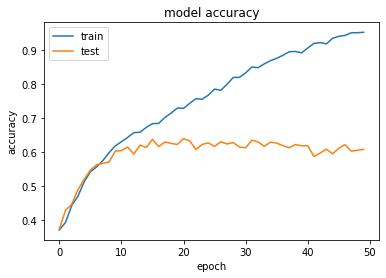

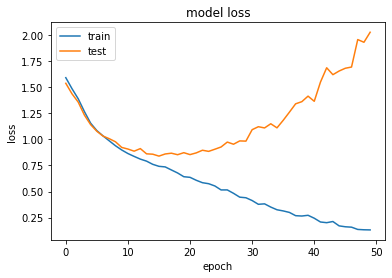

In [ ]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history_age.history['accuracy'])
plt.plot(history_age.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_age.history['loss'])
plt.plot(history_age.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Experiment on adding multiple convo layers for the sake of analysing the perfromance

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(100,100,1)))
model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Conv2D(256, kernel_size=3, activation='relu'))
model.add(Conv2D(256, kernel_size=3, activation='relu'))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
              
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())              
                           
history_age = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=256,
                    validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 21, 21, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 19, 19, 128)      

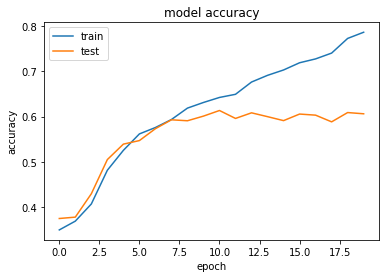

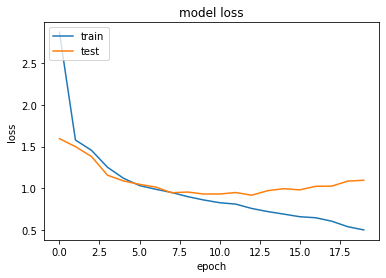

In [ ]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history_age.history['accuracy'])
plt.plot(history_age.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_age.history['loss'])
plt.plot(history_age.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(100,100,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=3, strides=2))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=3, strides=2))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(Conv2D(256, kernel_size=3, activation='relu'))



model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
              
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())              
                           
history_age = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=256,
                    validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 98, 98, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 conv2d_12 (Conv2D)          (None, 43, 43, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 21, 21, 64)       0         
 2D)                                                  

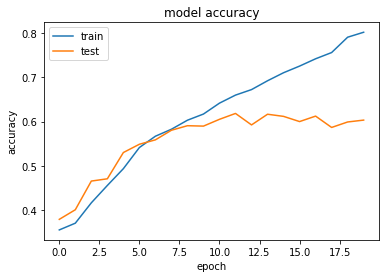

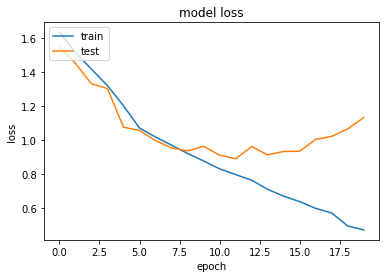

In [ ]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history_age.history['accuracy'])
plt.plot(history_age.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_age.history['loss'])
plt.plot(history_age.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Around 7-8 epochs model is trying to overfit itself even when adding new layers

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(100,100,1)))
model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Conv2D(256, kernel_size=3, activation='relu'))
model.add(Conv2D(256, kernel_size=3, activation='relu'))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
              
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())              
                           
history_age = model.fit(X_train, y_train,
                    epochs=8,
                    batch_size=256,
                    validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 19, 19, 128)       7

In [ ]:



#argmax is a function which gives the index of the greatest number in the given row or column 
#And the row or column can be decided using axis attribute of argmax funcion. 
#If we give axis=0 then it will give the index from columns 
#And if we give axis=1 then it will give the index from rows.
y_pred=model.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test_argmax=np.argmax(y_test, axis=1)


accuracy = accuracy_score(y_test_argmax,y_pred)
#we need to add the 'average' param in the precision, recall & f1 score in multiclass 
precision = precision_score(y_test_argmax,y_pred, average='weighted')
recall=recall_score(y_test_argmax,y_pred, average='weighted')
f1 = f1_score(y_test_argmax,y_pred, average='weighted')

print("Accuracy: "+str(accuracy)+"\nPrecision: "+str(precision)+"\nRecall: "+str(recall)+"\nF1 Score: "+str(f1))


149/149 [==============================] - 2s 8ms/step
Accuracy: 0.5704344158582877
Precision: 0.5468031826771185
Recall: 0.5704344158582877
F1 Score: 0.5425373128418456


### Applying the augmentation in order to improve the performance

In [ ]:

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

train_datagen.fit(X_train)

In [ ]:
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)
print("X_val shape", X_val.shape)
print("y_val shape", y_val.shape)

X_train shape (17069, 100, 100, 1)
y_train shape (17069, 6)
X_test shape (4742, 100, 100, 1)
y_test shape (4742, 6)
X_val shape (1897, 100, 100, 1)
y_val shape (1897, 6)


In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(100,100,1)))
model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Conv2D(256, kernel_size=3, activation='relu',padding="same"))
model.add(Conv2D(256, kernel_size=3, activation='relu',padding="same"))
model.add(Conv2D(256, kernel_size=3, activation='relu',padding="same"))
model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))
              
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:

history_age = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=256),
    steps_per_epoch=(len(X_train) // 256),
    validation_data=(X_val, y_val),
    epochs=50
)

Epoch 1/50
66/66 [==============================] - 20s 295ms/step - loss: 1.6155 - accuracy: 0.3482 - val_loss: 1.5635 - val_accuracy: 0.3595
Epoch 2/50
66/66 [==============================] - 20s 293ms/step - loss: 1.5333 - accuracy: 0.3840 - val_loss: 1.4933 - val_accuracy: 0.4070
Epoch 3/50
66/66 [==============================] - 20s 296ms/step - loss: 1.5068 - accuracy: 0.4005 - val_loss: 1.4666 - val_accuracy: 0.4180
Epoch 4/50
66/66 [==============================] - 22s 337ms/step - loss: 1.4908 - accuracy: 0.4035 - val_loss: 1.4259 - val_accuracy: 0.4354
Epoch 5/50
66/66 [==============================] - 19s 281ms/step - loss: 1.4523 - accuracy: 0.4188 - val_loss: 1.4249 - val_accuracy: 0.4291
Epoch 6/50
66/66 [==============================] - 19s 281ms/step - loss: 1.3993 - accuracy: 0.4319 - val_loss: 1.3184 - val_accuracy: 0.4502
Epoch 7/50
66/66 [==============================] - 19s 281ms/step - loss: 1.3549 - accuracy: 0.4432 - val_loss: 1.2304 - val_accuracy: 0.4750

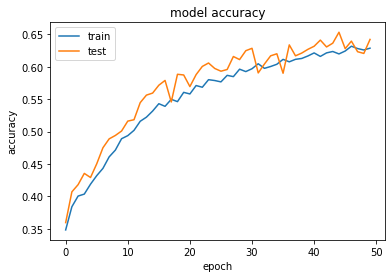

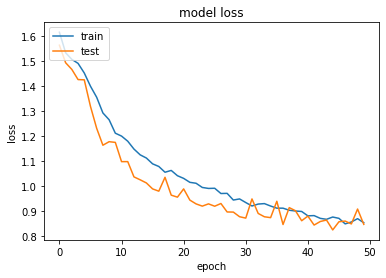

In [ ]:

plt.plot(history_age.history['accuracy'])
plt.plot(history_age.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_age.history['loss'])
plt.plot(history_age.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:



#argmax is a function which gives the index of the greatest number in the given row or column 
#And the row or column can be decided using axis attribute of argmax funcion. 
#If we give axis=0 then it will give the index from columns 
#And if we give axis=1 then it will give the index from rows.
y_pred=model.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test_argmax=np.argmax(y_test, axis=1)


accuracy = accuracy_score(y_test_argmax,y_pred)
#we need to add the 'average' param in the precision, recall & f1 score in multiclass 
precision = precision_score(y_test_argmax,y_pred, average='weighted')
recall=recall_score(y_test_argmax,y_pred, average='weighted')
f1 = f1_score(y_test_argmax,y_pred, average='weighted')

print("Accuracy: "+str(accuracy)+"\nPrecision: "+str(precision)+"\nRecall: "+str(recall)+"\nF1 Score: "+str(f1))


149/149 [==============================] - 1s 9ms/step
Accuracy: 0.6231547870097005
Precision: 0.6108632212705806
Recall: 0.6231547870097005
F1 Score: 0.6135984122625592


In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(100,100,1)))
model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
              
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import keras
earlyStop = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max',patience=20,verbose=1)
bestWeightSave = keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/bestWeights.hdf5",
	save_best_only=True, verbose=1)

history_age = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=256),
    steps_per_epoch=(len(X_train) // 256),
    validation_data=(X_val, y_val),
    callbacks = [earlyStop,bestWeightSave],
    epochs=300
)

Epoch 1/300
66/66 [==============================] - ETA: 0s - loss: 1.5640 - accuracy: 0.3732
Epoch 1: val_loss improved from inf to 1.53457, saving model to /content/drive/MyDrive/bestWeights.hdf5
66/66 [==============================] - 18s 270ms/step - loss: 1.5640 - accuracy: 0.3732 - val_loss: 1.5346 - val_accuracy: 0.3595
Epoch 2/300
66/66 [==============================] - ETA: 0s - loss: 1.5120 - accuracy: 0.3842
Epoch 2: val_loss improved from 1.53457 to 1.46309, saving model to /content/drive/MyDrive/bestWeights.hdf5
66/66 [==============================] - 18s 265ms/step - loss: 1.5120 - accuracy: 0.3842 - val_loss: 1.4631 - val_accuracy: 0.4138
Epoch 3/300
66/66 [==============================] - ETA: 0s - loss: 1.4760 - accuracy: 0.4086
Epoch 3: val_loss improved from 1.46309 to 1.45412, saving model to /content/drive/MyDrive/bestWeights.hdf5
66/66 [==============================] - 20s 299ms/step - loss: 1.4760 - accuracy: 0.4086 - val_loss: 1.4541 - val_accuracy: 0.4122

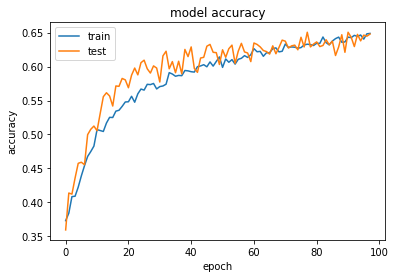

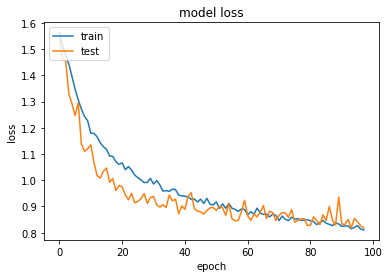

In [ ]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history_age.history['accuracy'])
plt.plot(history_age.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_age.history['loss'])
plt.plot(history_age.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(100,100,1),padding="same"))
model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Conv2D(64, kernel_size=3, activation='relu',padding="same"))
model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Conv2D(128, kernel_size=3, activation='relu',padding="same"))
model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Conv2D(256, kernel_size=3, activation='relu',padding="same"))
model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Conv2D(512, kernel_size=3, activation='relu',padding="same"))
model.add(MaxPool2D(pool_size=3, strides=2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
              
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import keras
earlyStop = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max',patience=40,verbose=1)
bestWeightSave = keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/bestWeights_2.hdf5",
	save_best_only=True, verbose=1)

history_age = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=256),
    steps_per_epoch=(len(X_train) // 256),
    validation_data=(X_val, y_val),
    callbacks = [earlyStop,bestWeightSave],
    epochs=300
)

Epoch 1/300
66/66 [==============================] - ETA: 0s - loss: 1.6014 - accuracy: 0.3519
Epoch 1: val_loss improved from inf to 1.52438, saving model to /content/drive/MyDrive/bestWeights_2.hdf5
66/66 [==============================] - 20s 283ms/step - loss: 1.6014 - accuracy: 0.3519 - val_loss: 1.5244 - val_accuracy: 0.3595
Epoch 2/300
66/66 [==============================] - ETA: 0s - loss: 1.5171 - accuracy: 0.3926
Epoch 2: val_loss improved from 1.52438 to 1.49768, saving model to /content/drive/MyDrive/bestWeights_2.hdf5
66/66 [==============================] - 18s 275ms/step - loss: 1.5171 - accuracy: 0.3926 - val_loss: 1.4977 - val_accuracy: 0.3922
Epoch 3/300
66/66 [==============================] - ETA: 0s - loss: 1.4917 - accuracy: 0.4075
Epoch 3: val_loss improved from 1.49768 to 1.44330, saving model to /content/drive/MyDrive/bestWeights_2.hdf5
66/66 [==============================] - 18s 272ms/step - loss: 1.4917 - accuracy: 0.4075 - val_loss: 1.4433 - val_accuracy: 

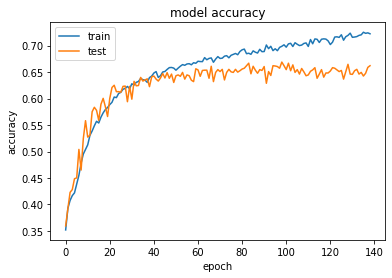

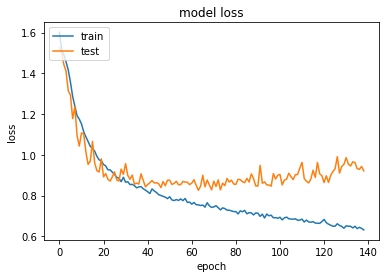

In [ ]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history_age.history['accuracy'])
plt.plot(history_age.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_age.history['loss'])
plt.plot(history_age.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Machine Learning/Final Project/bestWeights_2.hdf5')

In [ ]:



#argmax is a function which gives the index of the greatest number in the given row or column 
#And the row or column can be decided using axis attribute of argmax funcion. 
#If we give axis=0 then it will give the index from columns 
#And if we give axis=1 then it will give the index from rows.
y_pred=model.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test_argmax=np.argmax(y_test, axis=1)


accuracy = accuracy_score(y_test_argmax,y_pred)
#we need to add the 'average' param in the precision, recall & f1 score in multiclass 
precision = precision_score(y_test_argmax,y_pred, average='weighted')
recall=recall_score(y_test_argmax,y_pred, average='weighted')
f1 = f1_score(y_test_argmax,y_pred, average='weighted')

print("Accuracy: "+str(accuracy)+"\nPrecision: "+str(precision)+"\nRecall: "+str(recall)+"\nF1 Score: "+str(f1))


149/149 [==============================] - 1s 9ms/step
Accuracy: 0.644664698439477
Precision: 0.6444066084782705
Recall: 0.644664698439477
F1 Score: 0.642343869111244


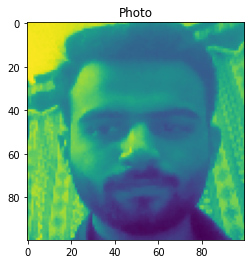

1/1 [==============================] - 0s 204ms/step


'16-30 (Young Adult)'

In [ ]:
import cv2
image=cv2.imread("/content/drive/MyDrive/Machine Learning/Final Project/face.PNG")

image=cv2.resize(image,(100,100))
image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
plt.imshow(image)
plt.title('Photo')
plt.show()


image = np.array(image)
image = image.reshape((-1, 100, 100, 1))
ageGroup(np.argmax(model.predict(image)))

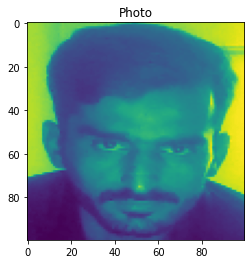

1/1 [==============================] - 0s 19ms/step


'16-30 (Young Adult)'

In [ ]:
image=cv2.imread("/content/drive/MyDrive/mujtaba.PNG")

image=cv2.resize(image,(100,100))
image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

plt.imshow(image)
plt.title('Photo')
plt.show()


image = np.array(image)
image = image.reshape((-1, 100, 100, 1))
ageGroup(np.argmax(model.predict(image)))

In [ ]:
def ageGroup(age):
  if age==0:
    return "1-4 (Baby)"
  elif age==1:
    return "5-15 (Child)"
  elif age==2:
    return "16-30 (Young Adult)"
  elif age==3:
    return "31-45 (Middle-aged Adult)"
  elif age==4:
    return "46-60 (Old Adult)"
  elif age==5:
    return "61-116 (Old)"


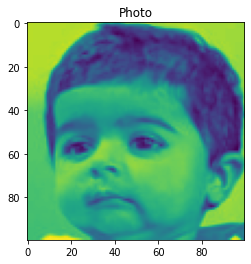

1/1 [==============================] - 0s 196ms/step


'5-15 (Child)'

In [ ]:
image=cv2.imread("/content/drive/MyDrive/Machine Learning/Final Project/baby2.PNG")

image=cv2.resize(image,(100,100))
image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

plt.imshow(image)
plt.title('Photo')
plt.show()


image = np.array(image)
image = image.reshape((-1, 100, 100, 1))
ageGroup(np.argmax(model.predict(image)))

### Gender detection part

### Importing required Modlues

In [ ]:
import os
import cv2
from google.colab.patches import cv2_imshow
import pickle
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Preparing the data

In [ ]:

genderList=pickle.load(open("/content/drive/MyDrive/Machine Learning/Final Project/genderList.pkl","rb"))
imagesList=pickle.load(open("/content/drive/MyDrive/Machine Learning/Final Project/imagesList.pkl","rb"))

In [ ]:

images = np.array(imagesList)
gender = np.array(genderList,np.uint64)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, gender,stratify=gender, random_state=5, )


In [ ]:
X_train  = X_train.reshape((-1, 100, 100, 1))
X_train = X_train.astype('float32') / 255

X_test  = X_test.reshape((-1, 100, 100, 1))
X_test = X_test.astype('float32') / 255


### Training the model

In [ ]:
gender_model = Sequential()

gender_model.add(Conv2D(36, kernel_size=3, activation='relu', input_shape=(100,100,1)))

gender_model.add(MaxPool2D(pool_size=3, strides=2))
gender_model.add(Conv2D(64, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=3, strides=2))

gender_model.add(Conv2D(128, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=3, strides=2))

gender_model.add(Conv2D(256, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=3, strides=2))

gender_model.add(Conv2D(512, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=1, strides=2))

gender_model.add(Flatten())
gender_model.add(Dropout(0.2))
gender_model.add(Dense(512, activation='relu'))
gender_model.add(Dense(1, activation='sigmoid', name='gender'))

gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])





In [ ]:
history_gender = gender_model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=512,
                    validation_split=0.2)


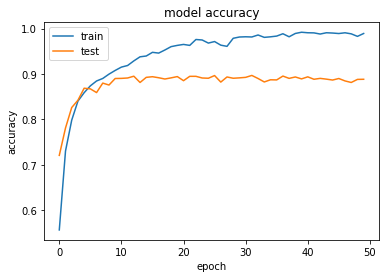

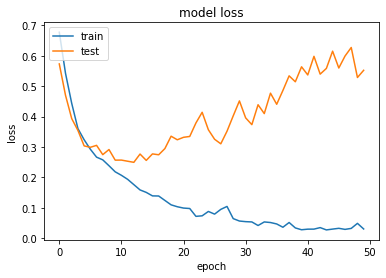

In [ ]:

# summarize history for accuracy
plt.plot(history_gender.history['accuracy'])
plt.plot(history_gender.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_gender.history['loss'])
plt.plot(history_gender.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Around 6-7 epoch the model is doing overfitting

In [ ]:
history_gender = gender_model.fit(X_train, y_train,
                    epochs=6,
                    batch_size=512,
                    validation_split=0.2)

Epoch 1/6
28/28 [==============================] - 7s 220ms/step - loss: 0.6844 - accuracy: 0.5578 - val_loss: 0.7183 - val_accuracy: 0.5142
Epoch 2/6
28/28 [==============================] - 6s 209ms/step - loss: 0.6531 - accuracy: 0.6097 - val_loss: 0.5760 - val_accuracy: 0.7127
Epoch 3/6
28/28 [==============================] - 6s 211ms/step - loss: 0.5381 - accuracy: 0.7316 - val_loss: 0.4778 - val_accuracy: 0.7779
Epoch 4/6
28/28 [==============================] - 6s 212ms/step - loss: 0.4500 - accuracy: 0.7933 - val_loss: 0.3964 - val_accuracy: 0.8249
Epoch 5/6
28/28 [==============================] - 6s 214ms/step - loss: 0.3792 - accuracy: 0.8294 - val_loss: 0.3615 - val_accuracy: 0.8417
Epoch 6/6
28/28 [==============================] - 6s 213ms/step - loss: 0.3308 - accuracy: 0.8553 - val_loss: 0.3249 - val_accuracy: 0.8586


In [ ]:
y_pred =gender_model.predict(X_test)

186/186 [==============================] - 2s 6ms/step


In [ ]:

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test,y_pred.round())
print("Accuracy:"+str(accuracy))

Accuracy:0.8456217310612452


### Applying the augmentation

In [ ]:

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

train_datagen.fit(X_train)

In [ ]:
gender_model = Sequential()

gender_model.add(Conv2D(36, kernel_size=3, activation='relu', input_shape=(100,100,1)))

gender_model.add(MaxPool2D(pool_size=3, strides=2))
gender_model.add(Conv2D(64, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=3, strides=2))

gender_model.add(Conv2D(128, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=3, strides=2))

gender_model.add(Conv2D(256, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=3, strides=2))

gender_model.add(Conv2D(512, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=1, strides=2))

gender_model.add(Flatten())
gender_model.add(Dropout(0.2))
gender_model.add(Dense(512, activation='relu'))
gender_model.add(Dense(1, activation='sigmoid', name='gender'))

gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])





In [ ]:
# # Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle = True,
    test_size=0.1, random_state= 8) # 



In [ ]:

history_gender = gender_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=256),
    steps_per_epoch=(len(X_train) // 256),
   validation_data=(X_val, y_val),
    epochs=50
)

Epoch 1/50
62/62 [==============================] - 18s 264ms/step - loss: 0.6660 - accuracy: 0.5907 - val_loss: 0.6117 - val_accuracy: 0.6577
Epoch 2/50
62/62 [==============================] - 15s 247ms/step - loss: 0.6229 - accuracy: 0.6555 - val_loss: 0.5492 - val_accuracy: 0.7274
Epoch 3/50
62/62 [==============================] - 16s 252ms/step - loss: 0.5915 - accuracy: 0.6867 - val_loss: 0.5089 - val_accuracy: 0.7617
Epoch 4/50
62/62 [==============================] - 15s 248ms/step - loss: 0.5408 - accuracy: 0.7318 - val_loss: 0.4455 - val_accuracy: 0.7993
Epoch 5/50
62/62 [==============================] - 16s 250ms/step - loss: 0.5230 - accuracy: 0.7410 - val_loss: 0.4224 - val_accuracy: 0.8156
Epoch 6/50
62/62 [==============================] - 16s 252ms/step - loss: 0.4724 - accuracy: 0.7763 - val_loss: 0.3824 - val_accuracy: 0.8302
Epoch 7/50
62/62 [==============================] - 15s 245ms/step - loss: 0.4717 - accuracy: 0.7758 - val_loss: 0.3625 - val_accuracy: 0.8471

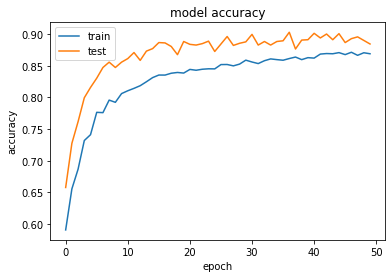

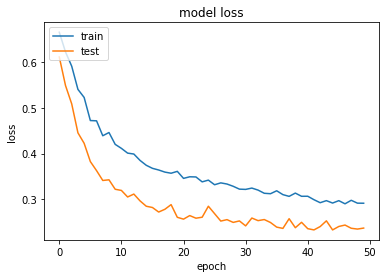

In [ ]:

# summarize history for accuracy
plt.plot(history_gender.history['accuracy'])
plt.plot(history_gender.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_gender.history['loss'])
plt.plot(history_gender.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
gender_model = Sequential()

gender_model.add(Conv2D(36, kernel_size=3, activation='relu', input_shape=(100,100,1)))

gender_model.add(MaxPool2D(pool_size=3, strides=2))
gender_model.add(Conv2D(64, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=3, strides=2))

gender_model.add(Conv2D(128, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=3, strides=2))

gender_model.add(Conv2D(256, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=3, strides=2))

gender_model.add(Conv2D(512, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=1, strides=2))

gender_model.add(Flatten())
gender_model.add(Dropout(0.2))
gender_model.add(Dense(512, activation='relu'))
gender_model.add(Dense(1, activation='sigmoid', name='gender'))

gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])





In [ ]:
import keras
earlyStop = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max',patience=20,verbose=1)
bestWeightSave = keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/bestWeightsForGender.hdf5",
	save_best_only=True, verbose=1)
history_gender = gender_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=256),
    steps_per_epoch=(len(X_train) // 256),
   validation_data=(X_val, y_val),
   callbacks = [earlyStop,bestWeightSave],
    epochs=150
)

Epoch 1/150
62/62 [==============================] - ETA: 0s - loss: 0.6888 - accuracy: 0.5377
Epoch 1: val_loss improved from inf to 0.65313, saving model to /content/drive/MyDrive/bestWeightsForGender.hdf5
62/62 [==============================] - 20s 288ms/step - loss: 0.6888 - accuracy: 0.5377 - val_loss: 0.6531 - val_accuracy: 0.6734
Epoch 2/150
62/62 [==============================] - ETA: 0s - loss: 0.6360 - accuracy: 0.6416
Epoch 2: val_loss improved from 0.65313 to 0.59533, saving model to /content/drive/MyDrive/bestWeightsForGender.hdf5
62/62 [==============================] - 18s 291ms/step - loss: 0.6360 - accuracy: 0.6416 - val_loss: 0.5953 - val_accuracy: 0.6830
Epoch 3/150
62/62 [==============================] - ETA: 0s - loss: 0.6092 - accuracy: 0.6736
Epoch 3: val_loss improved from 0.59533 to 0.52426, saving model to /content/drive/MyDrive/bestWeightsForGender.hdf5
62/62 [==============================] - 17s 276ms/step - loss: 0.6092 - accuracy: 0.6736 - val_loss: 0.

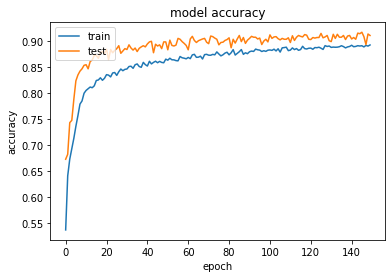

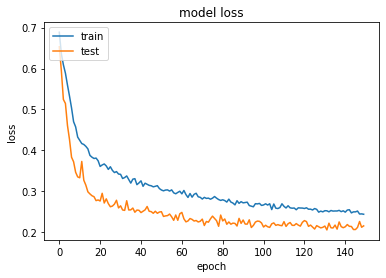

In [ ]:

# summarize history for accuracy
plt.plot(history_gender.history['accuracy'])
plt.plot(history_gender.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_gender.history['loss'])
plt.plot(history_gender.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Around 145 epoch the model is good enough

In [ ]:

history_gender = gender_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=256),
    steps_per_epoch=(len(X_train) // 256),
   validation_data=(X_val, y_val),
    epochs=145
)

Epoch 1/145
62/62 [==============================] - 17s 259ms/step - loss: 0.6699 - accuracy: 0.5732 - val_loss: 0.5870 - val_accuracy: 0.6981
Epoch 2/145
62/62 [==============================] - 17s 273ms/step - loss: 0.6058 - accuracy: 0.6761 - val_loss: 0.5186 - val_accuracy: 0.7521
Epoch 3/145
62/62 [==============================] - 16s 258ms/step - loss: 0.5708 - accuracy: 0.7033 - val_loss: 0.4660 - val_accuracy: 0.7943
Epoch 4/145
62/62 [==============================] - 16s 263ms/step - loss: 0.5256 - accuracy: 0.7414 - val_loss: 0.4065 - val_accuracy: 0.8111
Epoch 5/145
62/62 [==============================] - 15s 249ms/step - loss: 0.4839 - accuracy: 0.7693 - val_loss: 0.3842 - val_accuracy: 0.8314
Epoch 6/145
62/62 [==============================] - 20s 326ms/step - loss: 0.4623 - accuracy: 0.7825 - val_loss: 0.3718 - val_accuracy: 0.8336
Epoch 7/145
62/62 [==============================] - 22s 349ms/step - loss: 0.4457 - accuracy: 0.7943 - val_loss: 0.3435 - val_accuracy:

In [ ]:

y_pred=gender_model.predict(X_test) 

accuracy = accuracy_score(y_test,y_pred.round())
precision = precision_score(y_test,y_pred.round())
recall=recall_score(y_test,y_pred.round())
f1 = f1_score(y_test,y_pred.round())

print("Accuracy: "+str(accuracy)+"\nPrecision: "+str(precision)+"\nRecall: "+str(recall)+"\nF1 Score: "+str(f1))


186/186 [==============================] - 1s 6ms/step
Accuracy: 0.8965749957820145
Precision: 0.9181132075471699
Recall: 0.8600212089077413
F1 Score: 0.888118269757255


### Saving the model

In [ ]:
gender_model.save("/content/drive/MyDrive/Machine Learning/Final Project/bestGenderModel.hdf5")

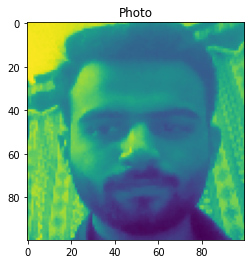

1/1 [==============================] - 0s 14ms/step
Male


In [ ]:
import cv2
image=cv2.imread("/content/drive/MyDrive/Machine Learning/Final Project/face.PNG")

image=cv2.resize(image,(100,100))
image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
plt.imshow(image)
plt.title('Photo')
plt.show()

image = image.reshape((-1, 100, 100, 1))
if gender_model.predict(image)==0:
  print("Male")
else:
  print("Female")


### Summary of the project

In [ ]:
expList = ["Decision Tree Classifier for age group  detection","Logistic regression for age group detection ","Revised CNN for age group detection","Revised CNN with augmentation for age group detection","Revised CNN for gender detection","Revised CNN with augmentation for gender detection"]
accList = [0.3679881,
0.546183,
0.57043,
0.644664,
0.8456,
0.89657]


for i in range(6):
  accList[i] = "{:.2f}".format(accList[i]*100)+"%"

summary = pd.DataFrame({"Experiment":expList,"Testing Accuracy":accList})
summary

,Experiment,Testing Accuracy
0,Decision Tree Classifier for age group detection,36.80%
1,Logistic regression for age group detection,54.62%
2,Revised CNN for age group detection,57.04%
3,Revised CNN with augmentation for age group de...,64.47%
4,Revised CNN for gender detection,84.56%
5,Revised CNN with augmentation for gender detec...,89.66%
